In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Copyright (C) 2018 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""
from __future__ import print_function
from data_loader import SYSUDataTest, eval_sysu
from torch.utils.data import DataLoader
import sys
import scipy.io
sys.path.append('.')
from utils import get_config
from trainer import DGNet_Trainer, to_gray
import argparse
from torch.autograd import Variable
import sys
import torch
import os
import numpy as np
from torchvision import datasets, transforms
from PIL import Image
try:
    from itertools import izip as zip
except ImportError: # will be 3.x series
    pass

name = '1_Structure_as_id_triplet'

if not os.path.isdir('./outputs/%s'%name):
    assert 0, "please change the name to your model name"

parser = argparse.ArgumentParser()
parser.add_argument('--output_folder', type=str, default="./", help="output image path")
parser.add_argument('--input_folder', type=str, default="./visual_data/train_sysu", help="input image path")

parser.add_argument('--config', type=str, default='./outputs/%s/config.yaml'%name, help="net configuration")
parser.add_argument('--checkpoint_gen', type=str, default="./outputs/%s/checkpoints/gen_00100000.pt"%name, help="checkpoint of autoencoders")
parser.add_argument('--checkpoint_id', type=str, default="./outputs/%s/checkpoints/id_00100000.pt"%name, help="checkpoint of autoencoders")
parser.add_argument('--batchsize', default=1, type=int, help='batchsize')
parser.add_argument('--a2b', type=int, default=1, help="1 for a2b and others for b2a")
parser.add_argument('--seed', type=int, default=10, help="random seed")
parser.add_argument('--synchronized', action='store_true', help="whether use synchronized style code or not")
parser.add_argument('--output_only', action='store_true', help="whether use synchronized style code or not")
parser.add_argument('--trainer', type=str, default='DGNet', help="DGNet")
parser.add_argument('--use_dense', action='store_true', help='use densenet121' )
parser.add_argument('--PCB', action='store_true', help='use PCB' )
parser.add_argument('--query_index', default=100, type=int, help='test_image_index')
parser.add_argument('--test_dir',default='SYSU/pytorch',type=str, help='./test_data')

opts = parser.parse_args(args=[])

# opts.checkpoint_gen = 'outputs/E0.5new_reid0.5_w30000_rgb_ir_iter_30K/outputs/E0.5new_reid0.5_w30000/checkpoints/gen_00100000.pt'
# opts.checkpoint_id = 'outputs/E0.5new_reid0.5_w30000_rgb_ir_iter_30K/outputs/E0.5new_reid0.5_w30000/checkpoints/id_00100000.pt'

This is not an error. If you want to use low precision, i.e., fp16, please install the apex with cuda support (https://github.com/NVIDIA/apex) and update pytorch to 1.0


In [33]:
model_number = '00122000'
model_path = 'outputs/1_Structure_as_id_triplet'

opts.checkpoint_gen = 'outputs/'+name+'/checkpoints/gen_00122000.pt'
opts.checkpoint_id = 'outputs/'+name+'/checkpoints/dis_00122000.pt'

# opts.checkpoint_gen = model_path+'/checkpoints/gen_'+model_number+'.pt'
# opts.checkpoint_id = model_path+'/checkpoints/id_'+model_number+'.pt'

print(opts.checkpoint_gen)
torch.manual_seed(opts.seed)
torch.cuda.manual_seed(opts.seed)
if not os.path.exists(opts.output_folder):
    os.makedirs(opts.output_folder)

# Load experiment setting
config = get_config(opts.config)
opts.num_style = 1

# Setup model and data loader
if opts.trainer == 'DGNet':
    trainer = DGNet_Trainer(config)
else:
    sys.exit("Only support DGNet")

state_dict_gen = torch.load(opts.checkpoint_gen)
trainer.gen_a.load_state_dict(state_dict_gen['a'], strict=False)
trainer.gen_b = trainer.gen_a

state_dict_id = torch.load(opts.checkpoint_id)
trainer.id_a.load_state_dict(state_dict_id['a'], strict=False)
trainer.id_b = trainer.id_a

trainer.cuda()
trainer.eval()
encode = trainer.gen_a.encode # encode function
style_encode = trainer.gen_a.encode # encode function
id_encode = trainer.id_a # encode function
decode = trainer.gen_a.decode # decode function
single = to_gray(False)

data_transforms = transforms.Compose([
        transforms.Resize((256,128), interpolation=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


dataset_path = './SYSU-MM01/exp/test_id.txt'
dataset = SYSUDataTest(dataset_path,  mode='All', shot='Single', transform=data_transforms)
dataset.gallery = 0
print('len of dataset = ',len(dataset))
def to_gray(half=False): #simple
    def forward(x):
        x = torch.mean(x, dim=1, keepdim=True)
        if half:
            x = x.half()
        return x
    return forward

def norm(f):
#     print('before squeeze = ',f.shape)
#     f = f.squeeze()
#     print('after squeeze = ',f.shape)
    fnorm = torch.norm(f, p=2, dim=1, keepdim=True)
    f = f.div(fnorm.expand_as(f)) # Found the norm for each data point, then divided each data point with its norm, simple
    return f

def fliplr(img):
    '''flip horizontal'''
    inv_idx = torch.arange(img.size(3)-1,-1,-1).long()  # N x C x H x W
    img_flip = img.index_select(3,inv_idx)
    return img_flip

def extract_feature(model,data):
    features = torch.FloatTensor()
    img = data
    n, c, h, w = img.size()
    if opts.use_dense:
        ff = torch.FloatTensor(n,1024).zero_()
    else:
        ff = torch.FloatTensor(n,1024).zero_()
    if opts.PCB:
        ff = torch.FloatTensor(n,2048,6).zero_() # we have six parts
    for i in range(2):
        if(i==1):
            img = fliplr(img)
        input_img = Variable(img.cuda())
        f, x = model(single(input_img))
#         print('x0 = ',x[0].shape)
#         print('x1 = ',x[1].shape)
        x[0] = norm(x[0])
        x[1] = norm(x[1])
        f = torch.cat((x[0],x[1]), dim=1) #use 512-dim feature [751+751=1502 after concatenation of x[0] and x[1]]
        f = f.data.cpu()
        
#         ff = ff+f[:,:1024]
        

    ff[:, 0:512] = norm(ff[:, 0:512])
    ff[:, 512:1024] = norm(ff[:, 512:1024])
    
    # norm feature
    if opts.PCB:
        # feature size (n,2048,6)
        # 1. To treat every part equally, I calculate the norm for every 2048-dim part feature.
        # 2. To keep the cosine score==1, sqrt(6) is added to norm the whole feature (2048*6).
        fnorm = torch.norm(ff, p=2, dim=1, keepdim=True) * np.sqrt(6) 
        ff = ff.div(fnorm.expand_as(ff))
        ff = ff.view(ff.size(0), -1)
    

#     features = torch.cat((features,ff), 0)

    features = f
    return features

# GET QUERY FEATURES
def getQueryFeat(dataset):
    dataset.gallery = 0
    loader_probe = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=0, drop_last=False)
    probe_lab = []
    probe_cam = []

    for iteration, sampled_batch in enumerate(loader_probe):
        img_p, label_p, cam_p = sampled_batch
        f = extract_feature(encode,img_p)
#         img_p = Variable(img_p.cuda())
#         f, _ = id_encode(img_p)
        
        if iteration==0:
            probe = f
        else:
            probe = torch.cat((probe, f), 0)
        
        probe_lab.extend(label_p)
        probe_cam.extend(cam_p)
    probe_lab = torch.stack(probe_lab)
    probe_cam = torch.stack(probe_cam)
    print('Number of Query images = ',len(probe_lab))
    return probe, probe_lab, probe_cam
        
    
 # GET GALLERY FEATURES
    
def getGalleryFeat(dataset):

    dataset.gallery = 1
    loader_gallery = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=0, drop_last=False)
    gall_lab = []
    gall_cam = []

    for iteration, sampled_batch in enumerate(loader_gallery):
        img_g, label_g, cam_g = sampled_batch
        f = extract_feature(encode,img_g)
#         img_g = Variable(img_g.cuda())
#         f, _ = id_encode(img_g)

        if iteration==0:
            gallery = f
        else:
            gallery = torch.cat((gallery, f),0)        
        gall_lab.extend(label_g)
        gall_cam.extend(cam_g)

    gall_lab = torch.stack(gall_lab)
    gall_cam = torch.stack(gall_cam)        
    print('Number of Gallery images = ',len(gall_lab))
    return gallery, gall_lab, gall_cam

probe, probe_lab, probe_cam = getQueryFeat(dataset)
gallery, gall_lab, gall_cam = getGalleryFeat(dataset)

A = torch.matmul(probe.cuda(), gallery.cuda().T)
cmc_indoor_single, mAP_indoor_single, mINP = eval_sysu(-A.cpu(), np.array(probe_lab), np.array(gall_lab), np.array(probe_cam), np.array(gall_cam), max_rank = 20)
        
print('mAP_indoor_single = {:.2f}%'.format(mAP_indoor_single*100))
print('cmc_indoor_single = {0:.2f}% {1:.2f}% {2:.2f}%\n'.format(cmc_indoor_single[0]*100,cmc_indoor_single[9]*100,cmc_indoor_single[19]*100))

result = {'gallery_f':gallery.numpy(),'gallery_label':gall_lab.numpy(),'gallery_cam':gall_cam.numpy(),'query_f':probe.numpy(),'query_label':probe_lab.numpy(),'query_cam':probe_cam.numpy()}
scipy.io.savemat(model_path+'/pytorch_result_'+model_number+'.mat',result)

outputs/1_Structure_as_id_triplet/checkpoints/gen_00122000.pt
teacher hyperparameter =  None
len of dataset =  3803
Number of Query images =  3803
Number of Gallery images =  301
mAP_indoor_single = 14.54%
cmc_indoor_single = 11.49% 46.46% 64.66%



Query index =  240
Query label =  28
query_path =  SYSU/pytorch/query/0028/0001_cam3.jpg
Top 10 images are as follow:


/home/anirban/anaconda2/envs/chaitra1/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()
/home/anirban/anaconda2/envs/chaitra1/lib/python3.7/site-packages/ipykernel_launcher.py:108: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


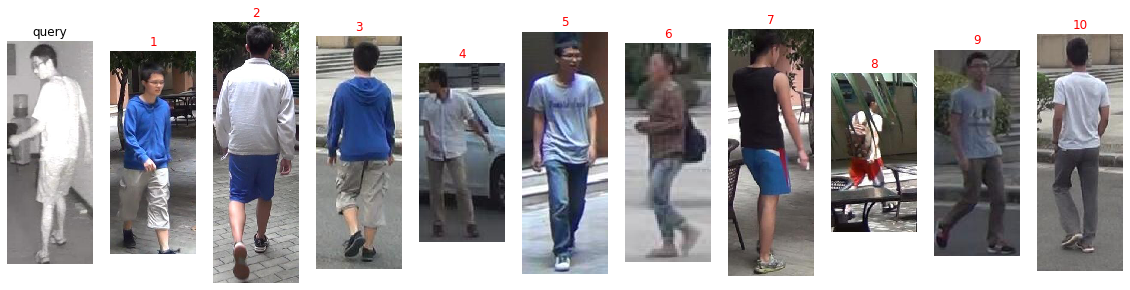

In [38]:
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

data_dir = opts.test_dir
image_datasets = {x: datasets.ImageFolder( os.path.join(data_dir,x) ) for x in ['gallery','query']}

#####################################################################
#Show result
def imshow(path, title=None):
    """Imshow for Tensor."""
    im = plt.imread(path)
    plt.imshow(im)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

######################################################################
# model_number = '00040000'
result = scipy.io.loadmat(model_path+'/pytorch_result_'+model_number+'.mat')
query_feature = torch.FloatTensor(result['query_f'])
query_cam = result['query_cam'][0]
query_label = result['query_label'][0]
gallery_feature = torch.FloatTensor(result['gallery_f'])
gallery_cam = result['gallery_cam'][0]
gallery_label = result['gallery_label'][0]

multi = os.path.isfile('multi_query.mat')
if multi:
    m_result = scipy.io.loadmat('multi_query.mat')
    mquery_feature = torch.FloatTensor(m_result['mquery_f'])
    mquery_cam = m_result['mquery_cam'][0]
    mquery_label = m_result['mquery_label'][0]
    mquery_feature = mquery_feature.cuda()

query_feature = query_feature.cuda()
gallery_feature = gallery_feature.cuda()

#######################################################################
# sort the images
def sort_img(qf, ql, qc, gf, gl, gc):
    query = qf.view(-1,1)
    
    score = torch.matmul(gf,query)
    score = score.squeeze(1).cpu()
    score = score.numpy()
    # predict index
    index = np.argsort(score)  #from small to large
    index = index[::-1] # Reversed the index
    # index = index[0:2000]
    # good index
    query_index = np.argwhere(gl==ql)
    #same camera
    
    if qc == 3:
        camera_index = np.argwhere(gc==2)
    else:
        camera_index = []
    
    #good_index = np.setdiff1d(query_index, camera_index, assume_unique=True)
    junk_index1 = np.argwhere(gl==-1)
    junk_index2 = np.intersect1d(query_index, camera_index)    
    junk_index = np.append(junk_index2, junk_index1) 
    
    mask = np.in1d(index, junk_index, invert=True)
    index = index[mask]
    return index

opts.query_index = 240
i = opts.query_index

print('Query index = ',i)
print('Query label = ',query_label[i])

index = sort_img(query_feature[i],query_label[i],query_cam[i],gallery_feature,gallery_label,gallery_cam)

########################################################################
# Visualize the rank result

query_path, _ = image_datasets['query'].imgs[i]
print('query_path = ',query_path)
query_label = query_label[i]
print('Top 10 images are as follow:')
try: # Visualize Ranking Result 
    # Graphical User Interface is needed
    fig = plt.figure(figsize=(20,5))
#     plt.title('query index = '+str(j)+' path = '+query_path)
    ax = plt.subplot(1,11,1)
    ax.axis('off')
    imshow(query_path,'query')
    for i in range(10):
        ax = plt.subplot(1,11,i+2)
        ax.axis('off')
        img_path, _ = image_datasets['gallery'].imgs[index[i]]
        label = gallery_label[index[i]]
        imshow(img_path)
        if label == query_label:
            ax.set_title('%d'%(i+1), color='green')
        else:
            ax.set_title('%d'%(i+1), color='red')
except RuntimeError:
    for i in range(10):
        img_path = image_datasets.imgs[index[i]]
        print(img_path[0])
    print('If you want to see the visualization of the ranking result, graphical user interface is needed.')

fig.savefig(model_path+'/top_10_'+model_number+'_.png')
plt.show()
